In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
from torchscan import summary

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import argparse

from torch.optim.lr_scheduler import StepLR,OneCycleLR

from train import *
from test import *
#from model import *
from plotter import *
from data import *
# from model_group_norm import *
# from model_layer_norm import *

#from parser_args import norm, epochs
from custom_resnet import *
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [2]:
# train dataloader
train_loader = load_train()

# test dataloader
test_loader = load_test()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [33]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 38.2 MB 8.1 MB/s eta 0:00:01
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.4.3
    Uninstalling albumentations-0.4.3:
      Successfully uninstalled albumentations-0.4.3


In [6]:
def train_transform(mean,std):
    # Train Phase transformations
    train_transforms = A.Compose([A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
                                  A.RandomCrop(width=32, height=32,p=1),
                                  A.HorizontalFlip(p=1),
                                  A.CoarseDropout(max_holes=3,min_holes = 1, max_height=8, max_width=8, p=0.8,fill_value=tuple([x * 255.0 for x in mean]),
                                  min_height=8, min_width=8),
                                  A.Normalize(mean=mean, std=std,always_apply=True),
                                  ToTensorV2()
                                ])
    return lambda img:train_transforms(image=np.array(img))["image"]
                                
def test_transform(mean,std):
    # Test Phase transformations
    test_transforms = A.Compose([A.Normalize(mean=mean, std=std, always_apply=True),
                             ToTensorV2()])
    return lambda img:test_transforms(image=np.array(img))["image"]

In [7]:
def calculate_mean_std():
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    mean = train_set.data.mean(axis=(0,1,2))/255
    std = train_set.data.std(axis=(0,1,2))/255
    return mean, std

In [8]:
mean,std=calculate_mean_std()

train_transforms, test_transforms = train_transform(mean,std),test_transform(mean,std)

Files already downloaded and verified


In [9]:
trainset = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transforms)  
            
testset  = datasets.CIFAR10(root='./data', train=False,
                                     transform=test_transforms)

# self.train_loader = torch.utils.data.DataLoader(trainset, 
#                                               batch_size=self.config['data_loader']['args']['batch_size'], 
#                                               shuffle=True,
#                                               num_workers=self.config['data_loader']['args']['num_workers'], 
#                                               pin_memory=self.config['data_loader']['args']['pin_memory'])
# self.test_loader = torch.utils.data.DataLoader(testset, 
#                                              batch_size=self.config['data_loader']['args']['batch_size'],  
#                                              shuffle=False,
#                                              num_workers=self.config['data_loader']['args']['num_workers'], 
#                                              pin_memory=self.config['data_loader']['args']['pin_memory'])

dataloader_args = dict(shuffle=False, batch_size=512, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

dataloader_args = dict(shuffle=False, batch_size=512, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


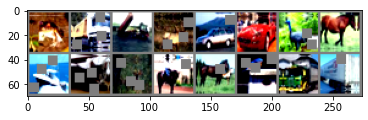

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images["image"]))

imshow(torchvision.utils.make_grid(images[:16]))
# print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True
